In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from fbprophet import Prophet
import time
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from get_anomaly_scores import get_anomaly_scores

# Gift Certificates Dataset

In [2]:
data = pd.read_csv('data/all_data_gift_certificates.csv')
data.head()

,BeginTime,Count
0,2016-01-01 00:00:00,0
1,2016-01-01 01:00:00,1
2,2016-01-01 02:00:00,2
3,2016-01-01 03:00:00,3
4,2016-01-01 04:00:00,1


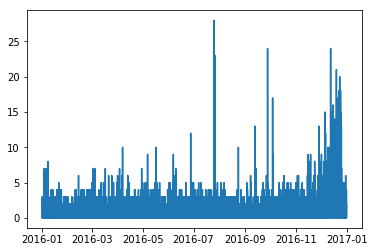

In [3]:
data["BeginTime"] = pd.to_datetime(data["BeginTime"], format="%Y-%m-%d %H:%M:%S")
plt.plot(data["BeginTime"], data["Count"])
plt.show()

## Daily seasonality

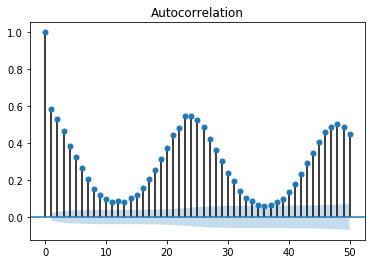

In [4]:
plot_acf(data["Count"], lags=50)
plt.show()

## Process for using Prophet:

1) Create a Prophet Model

2) Fit the Prophet Model

3) Make a forecast

## Prophet Parameters: see https://github.com/facebook/prophet/blob/master/python/fbprophet/forecaster.py


Notes: 

There are some other parameters like mcmc_samples, but that means you want to use MCMC sampling instead of MAP to determine parameters. This takes longer to fit. See https://facebook.github.io/prophet/docs/uncertainty_intervals.html

You can add other seasonalities (monthly, quarterly, hourly) using the add_seasonality method.

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities

## 1) Instantiate the model

In [5]:
model = Prophet(growth='linear',
                daily_seasonality=True,
                seasonality_mode='additive',
                )

Prophet's fit method has a very specific format for its input: it must be a Dataframe with a "ds" column for the date and "y" column for the values.

In [6]:
data.columns = ['ds', 'y']
data.head()

,ds,y
0,2016-01-01 00:00:00,0
1,2016-01-01 01:00:00,1
2,2016-01-01 02:00:00,2
3,2016-01-01 03:00:00,3
4,2016-01-01 04:00:00,1


We will have a training dataset and a testing dataset. 

In [7]:
train_data = data[:7000]
display(train_data.head())
display(train_data.tail())

,ds,y
0,2016-01-01 00:00:00,0
1,2016-01-01 01:00:00,1
2,2016-01-01 02:00:00,2
3,2016-01-01 03:00:00,3
4,2016-01-01 04:00:00,1


,ds,y
6995,2016-10-18 11:00:00,0
6996,2016-10-18 12:00:00,0
6997,2016-10-18 13:00:00,0
6998,2016-10-18 14:00:00,0
6999,2016-10-18 15:00:00,2


In [8]:
test_data = data[7000:]
display(test_data.head())
display(test_data.tail())

,ds,y
7000,2016-10-18 16:00:00,0
7001,2016-10-18 17:00:00,0
7002,2016-10-18 18:00:00,1
7003,2016-10-18 19:00:00,2
7004,2016-10-18 20:00:00,1


,ds,y
8779,2016-12-31 19:00:00,2
8780,2016-12-31 20:00:00,4
8781,2016-12-31 21:00:00,1
8782,2016-12-31 22:00:00,0
8783,2016-12-31 23:00:00,2


## 2) Fit the model

In [9]:
start = time.time()

model.fit(train_data)

end = time.time()

print("Time to fit: ", end - start)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Time to fit:  1.7850818634033203


We predict values using our Prophet model by passing in the dates for which we want to create a forecast. If we also supply the training data dates, then in addition to the prediction, we will get an in-sample fit for the training data. 

Prophet has no problem with missing data! If you set their values to NaNs in the training data but leave the dates in dates_to_predict, then Prophet will give you a prediction for their values.

In [10]:
dates_to_predict = model.make_future_dataframe(periods=len(test_data), freq='H')
display(dates_to_predict.head())
display(dates_to_predict.tail())

# The following only applies with logistic growth models

# To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified!!

# dates_to_predict['cap'] = 8.5
# dates_to_predict.head()

# dates_to_predict['floor'] = 0
# dates_to_predict.head()

,ds
0,2016-01-01 00:00:00
1,2016-01-01 01:00:00
2,2016-01-01 02:00:00
3,2016-01-01 03:00:00
4,2016-01-01 04:00:00


,ds
8779,2016-12-31 19:00:00
8780,2016-12-31 20:00:00
8781,2016-12-31 21:00:00
8782,2016-12-31 22:00:00
8783,2016-12-31 23:00:00


## 3) Predict

In [11]:
start = time.time()

forecast = model.predict(dates_to_predict)

end = time.time()

print("Time to predict: ", end - start)

print(forecast["yhat"])

Time to predict:  12.14882230758667
0       1.046629
1       0.907067
2       0.823366
3       0.785549
4       0.729908
5       0.604772
6       0.426333
7       0.266769
8       0.186543
9       0.180708
10      0.195339
11      0.197705
12      0.226037
13      0.361897
14      0.645427
15      1.014804
16      1.333538
17      1.487550
18      1.466823
19      1.359476
20      1.267287
21      1.222839
22      1.181814
23      1.088353
24      0.942087
25      0.799482
26      0.712374
27      0.670798
28      0.611058
29      0.481507
          ...   
8754    1.751924
8755    1.644990
8756    1.553214
8757    1.509179
8758    1.468567
8759    1.375520
8760    1.229667
8761    1.087474
8762    1.000780
8763    0.959617
8764    0.900291
8765    0.771152
8766    0.588421
8767    0.424311
8768    0.339326
8769    0.328567
8770    0.338162
8771    0.335438
8772    0.358692
8773    0.489552
8774    0.768233
8775    1.132987
8776    1.447402
8777    1.597477
8778    1.573272
8779    1.46

yhat = forecast

yhat_upper = upper confidence interval for forecast

yhat_lower = lower confidence interval for forecast

## Plot the components

Note that the trend component shows a confidence interval starting from the test set. Seasonality components WILL NOT have confidence intervals created by default in this plot.

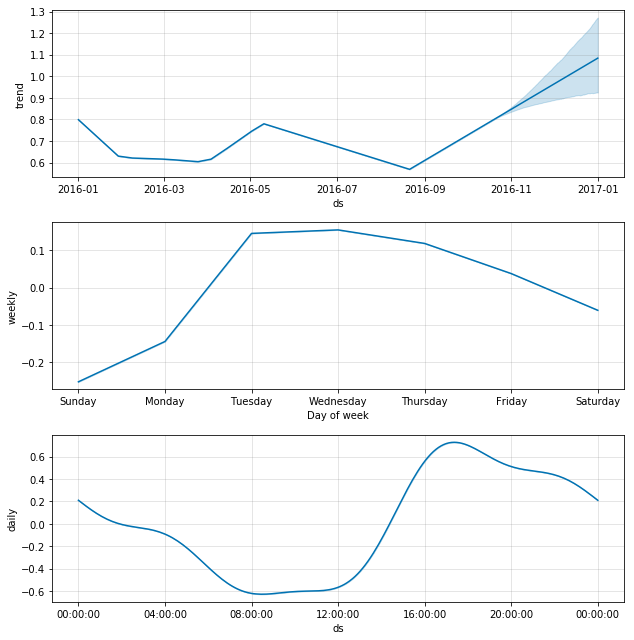

In [12]:
model.plot_components(forecast);

Captured the trend at the end. 

People don't really ask the IVA questions about Gift Certificates during the weekends or at night.

## Use built-in plot function

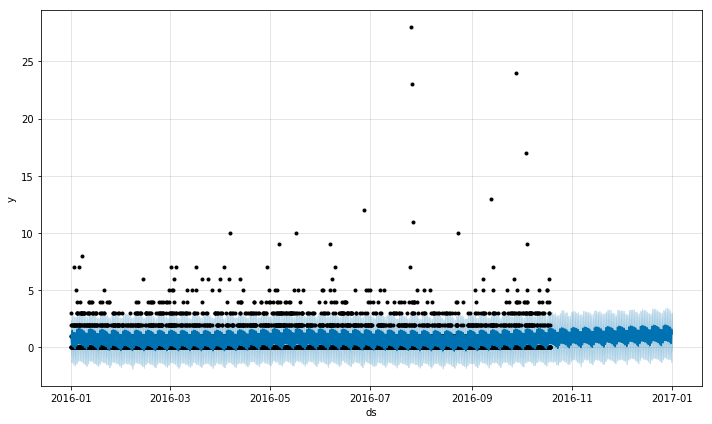

In [13]:
model.plot(forecast);

## Use matplotlib

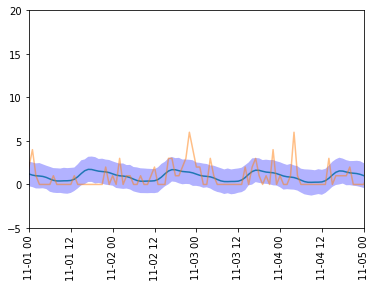

In [14]:
plt.plot(forecast["ds"],forecast["yhat"])

plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], facecolor='blue', alpha=.3)

plt.plot(data["ds"], data["y"], alpha=.5)

plt.xlim(["2016-11-01 00:00:00", "2016-11-05 00:00:00"])
plt.ylim([-5,20])
plt.xticks(rotation=90)
plt.show()

## Generating anomaly scores

1) Outside of the confidence interval...but creates a lot of false positives

2) Use the forecasting error

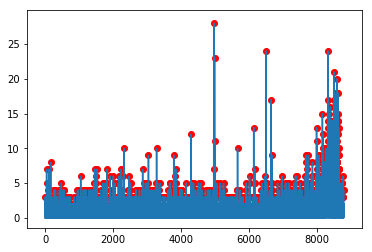

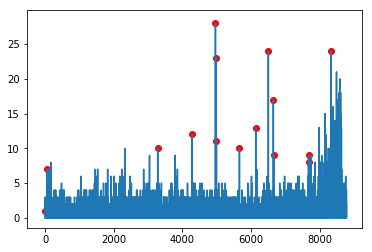

In [15]:
boundary = list(forecast["yhat_upper"].values)
actual = list(data["y"].values)

anomalies_x = []
anomalies_y = []
for i in range(len(boundary)):
    if boundary[i] < actual[i]:        
        anomalies_x.append(i)
        anomalies_y.append(data["y"].values[i])

plt.plot(data["y"])
plt.scatter(anomalies_x, anomalies_y, color="red")
plt.show()

predictions = list(forecast["yhat"].values)

errors = []
for i in range(len(predictions)):
    errors.append(actual[i] - predictions[i])

anomaly_scores = get_anomaly_scores(errors, window_size=20, step_size=100)
anomalies_x = []
anomalies_y = []
for i in range(len(anomaly_scores)):
    if anomaly_scores[i] == 1:
        anomalies_x.append(i)
        anomalies_y.append(data["y"].values[i])

plt.plot(data["y"])
plt.scatter(anomalies_x, anomalies_y, color="red")
plt.show()

# Tidbits

1) Github page for Prophet

https://github.com/facebook/prophet

2) Facebook Prophet paper

https://peerj.com/preprints/3190/

3) Prophet Docs

https://facebook.github.io/prophet/docs/installation.html